In [ ]:
from d3rlpy.lcb.run import *
from d3rlpy.lcb.util import *

In [2]:
def get_pkl(expt='fh'):
    """ Map this to each pickle file for each experiment - dataset combination
    
    Args:
        expt:(f, p, P, r) X (h, e, r)
    """
    qxlim = None
    pickle_output_filenames = []
    postfix_groups = None
    if expt[0] == 'f':
        env_name='FrozenLake-v1'
        if expt[1] == 'h':
            # Frozen Hard
            pass
        elif expt[1] == 'e':
            # Frozen easy
            pass
        elif expt[1] == 'r':
            # Frozen random
            pickle_output_filenames = [
#             "hparam_results_run_frozen_more_rand_all_10000.pkl", # run all algorithms to get this
            "data/hparam_results_run_frozen_more_rand_q_3162.pkl",
            "data/hparam_results_run_frozen_more_rand_ql_knownp_3162.pkl",
            ]
            qxlim=None
    elif expt[0] == 'r':
        env_name='Random-64x64-v0'
        if expt[1] == 'h':
            # Random Hard qling
            pass
        elif expt[1] == 'r':
            # Random Rand qling
            pass
        elif expt[1] == 'e':
            # Random Easy qling
            qxlim=60000
            pass
        
    elif expt == 'ph':
        # Portfolio Hard low
        pass
        env_name = 'PortEnv-Lo-v0'

    elif expt[0] == 'P':
        
        if expt[1] == 'h':
            # Portfolio Hard high
            pass
        elif expt[1] == 'r':
            pass
        elif expt[1] == 'e':
            pass
        env_name='PortEnv-Hi-v0'
        qxlim=21000
    else:
        print(f"expt {expt} not found")
        return None
    
    if postfix_groups is None:
        postfix_groups=[None] * (len(pickle_output_filenames) - 1) + [('knownp', 'Known P')]
    return pickle_output_filenames, env_name, postfix_groups, qxlim

pickle_output_filenames, env_name, postfix_groups, qxlim = get_pkl('fr')

## Functions to organize images and create tables 

In [3]:
import os
import re
import pandas as pd
# Make appropriate folders and rename the images
def rename_imgs(dir_to_search='.'):
    """Rename trainperf images"""
    search_strs = [r'(Port.*_N\d+)', r'(Random.*_N\d+)', r'(Frozen.*_N\d+)']
#     print(os.listdir(dir_to_search))
    for file in os.listdir(dir_to_search):
        if file[-4:] != '.png':
            continue
        print(file)
        for search_s in search_strs:
            search_file = re.search(r'trainperf.*'f'{search_s}', file)
            if search_file is not None:
                break
        if search_file is None:
            continue
        new_filename = search_file.groups()[0]
        print(f"renaming {file} to {dir_to_search}{new_filename}")
        os.rename(os.path.join(dir_to_search,file),  os.path.join(dir_to_search,new_filename+".png"))

from IPython.display import display, HTML
def make_tables(dir_to_search='.', filter_word="Port"):
    df = pd.read_csv(os.path.join(dir_to_search,os.listdir(dir_to_search)[1]))
    display(HTML(df.to_html(index=False)))
    final_df = pd.DataFrame(columns=['Num. Episodes'] + df['name'].tolist())
    # final_df = pd.DataFrame(columns=['Datasize (N)', 'ij_ker', 'sqrt'] + df['name'].tolist())
    print(f"searching {dir_to_search}")
    always_merge_cols = ['Dataset Size (N)']
    for file in os.listdir(dir_to_search):
        if file[-4:] != '.csv' or not filter_word in file:
            continue
        df = pd.read_csv(os.path.join(dir_to_search,file))
        print(file)
        sqrt = '_sqrt' in file
        ij_ker = '_ij' in file
        df = df.drop(columns=['std'])
        df['mean'] = df['mean'].apply(lambda x: f"{x:.2f}")
        new_row_df = df.set_index('name').T  # Get table with correct columns
        merge_cols = always_merge_cols.copy()
        ds_size = re.search(r'N(\d+)', file).group()[1:]
        new_row_df['Num. Episodes'] = int(ds_size)
        # Columns which might intersect
        merge_cols += [m for m in new_row_df.columns if m in final_df.columns and m not in always_merge_cols]
        final_df = final_df.merge(new_row_df,how='outer', on=merge_cols, copy=False)
    
#     col = final_df.pop('Num. Episodes')
#     final_df.insert(0, col.name, col)
    
#     test_df['Num. Episodes'].astype(int)
        
    sorted_df = final_df.sort_values(final_df.columns[0])

    n_col_ind = 'Dataset Size (N)'
    sorted_df[n_col_ind] = sorted_df[n_col_ind].apply(lambda x: f"{float(x.split()[0]):.2}")
    # sorted_df = sorted_df.drop('Off-VI LCB (Tuned)', axis=1)
    display(HTML(sorted_df.to_html(index=False)))
    return sorted_df.copy()

    
def make_combined_tables(dirs_to_search='.', filter_word='Port'):
    cols = []
    df_list =[]
    for dir_to_search in dirs_to_search:
        df = pd.read_csv(os.path.join(dir_to_search,os.listdir(dir_to_search)[1]))
        cols += [e for e in df['name'].tolist() if e not in cols]
        sorted_df = make_tables(dir_to_search, filter_word=filter_word)
        df_list.append(sorted_df)
    
    ne_col_name = 'Num. Episodes'
    always_merge_cols = [ne_col_name, 'Value Iteration', 'Dataset Size (N)']
    print("Merging")
    output_df  = df_list[0]
    for df2merge in df_list[1:]:
        merge_cols = always_merge_cols.copy()
        # Columns which might intersect
        merge_cols += [m for m in df2merge.columns if m in output_df.columns and m not in always_merge_cols]
        output_df = output_df.merge(df2merge, how='outer', on=merge_cols, copy=False)
    
    fixed_order = ['Num. Episodes', 'Dataset Size (N)', 'Value Iteration',
       'VI-LCB (Paper)', 'VI-LCB (Tuned)', 'IDP-VI (Ours)', 'VI-Vanilla',
       'CQL', 'Q-Learning', 'IDP-Q (Ours)', 'Q-Learning LCB',
       'IDP-Q (Ours) - Known P']
    try:
        output_df = output_df[fixed_order]
    except:
        print(f"Missing some columns! {dir_to_search} filter{filter_word}")
        print(f"files are {os.listdir(dir_to_search)}")
    
    # Format Output DF
    
    # Now sort
    output_df = output_df.sort_values(output_df.columns[0])
    display(HTML(output_df.to_html(index=False)))
    return output_df
        
def make_folders_and_move_then_rename(expt='fh', plots_made=True):
    """A function for use in ipython since using ! for bash expressions"""
    if expt[0] == 'f':
        env_short = 'frozen'
    elif expt[0] == 'P':
        env_short = 'port'
    elif expt[0] == 'p':
        env_short = 'portlow'
    elif expt[0] == 'r':
        env_short = 'random'
    else:
        assert False, "env not setup"
        
    if expt[1] == 'h':
        diff = 'hard'
    elif expt[1] == 'e':
        diff = 'easy'
    elif expt[1] == 'r':
        diff = 'rand'
    else:
        assert False, "difficulty not setup"
        
    
    filter_word = env_short[:4].capitalize()  # Word in filenames
    folder_list = []
    for mode in ['vi', 'qling']:
        exp_folder_name = f"{mode}_{env_short}_{diff}"
        exp_start_name = f'plot_{mode}_subset_{expt}'
        if plots_made:
            !mkdir img/{exp_folder_name}
            !mkdir log/{exp_folder_name}
            !mv img/{exp_start_name}* img/trainperf_{exp_start_name}* img/{exp_folder_name}/
            !mv log/{exp_start_name}* log/{exp_folder_name}/
            rename_imgs(f'img/{exp_folder_name}/')
        folder_list.append(f'log/{exp_folder_name}/')
        make_tables(folder_list[-1], filter_word=filter_word)
    return make_combined_tables(folder_list, filter_word=filter_word)

def filter_subset_expt(expt, run_subset):
    filtered_subset = run_subset.copy()
#     if expt == 'rr' and lcb_extension in run_subset:
#         filtered_subset.remove(lcb_extension)
    return filtered_subset

## Create all plots

Plotting for 10
keys: dict_keys(['0_valiter', '0_qling-dsd', '0_qling', '0_qling-lcb', '1_valiter', '1_qling-dsd', '1_qling', '1_qling-lcb', '2_valiter', '2_qling-dsd', '2_qling', '2_qling-lcb', '3_valiter', '3_qling-dsd', '3_qling', '3_qling-lcb', '4_valiter', '4_qling-dsd', '4_qling', '4_qling-lcb', 'extra_info'])


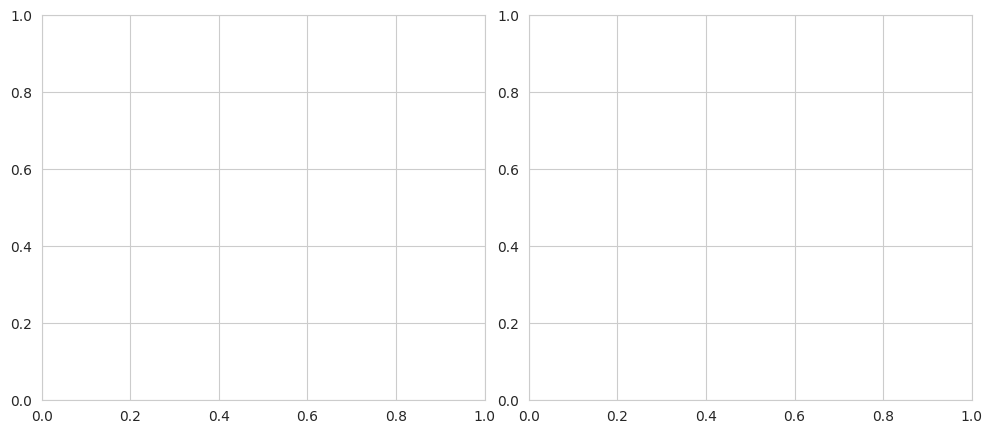

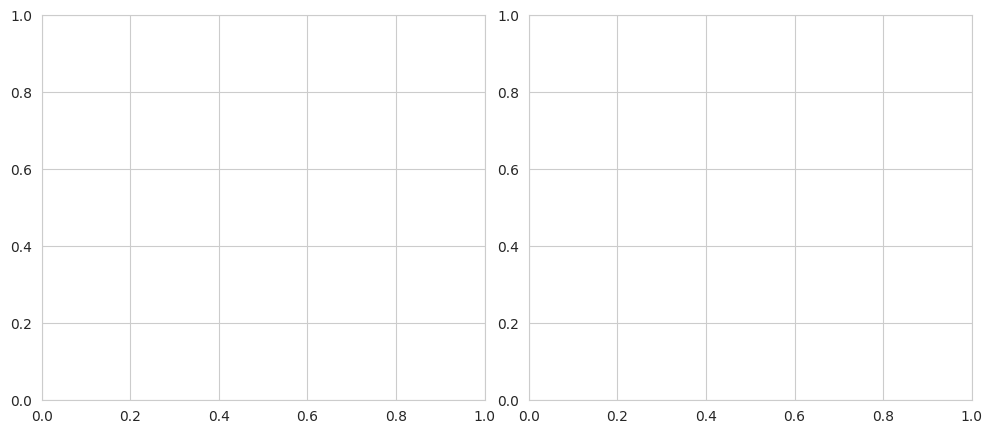

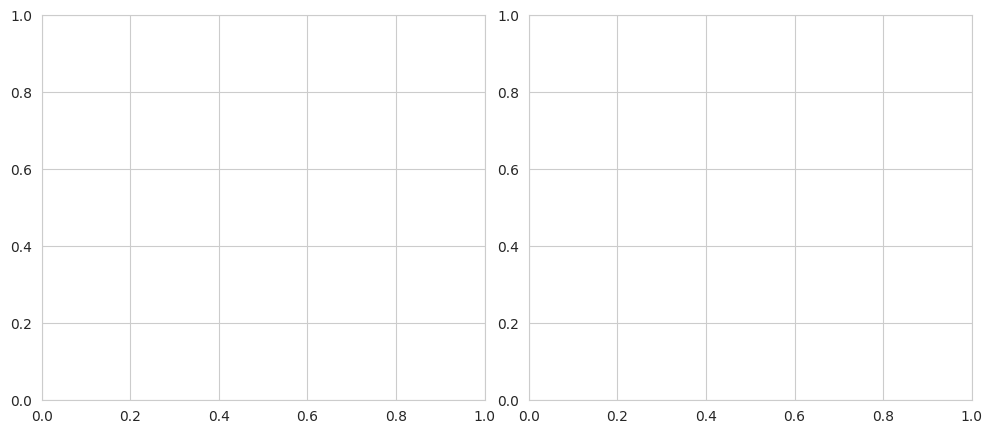

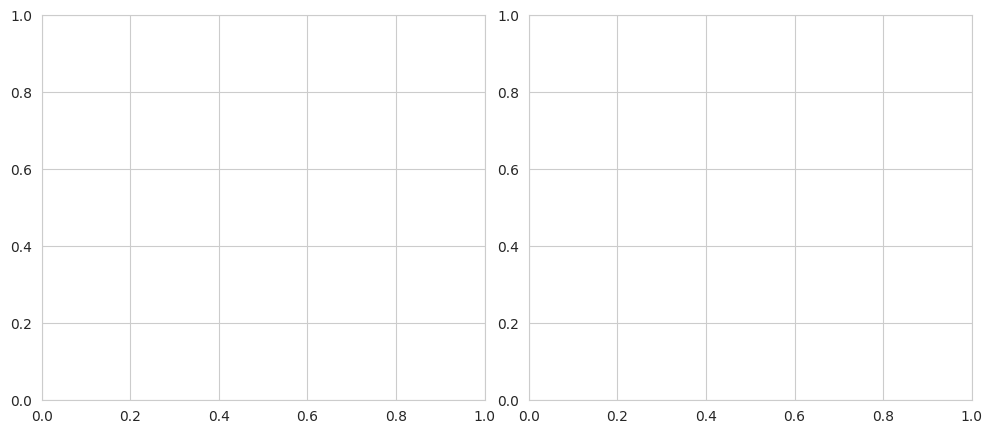

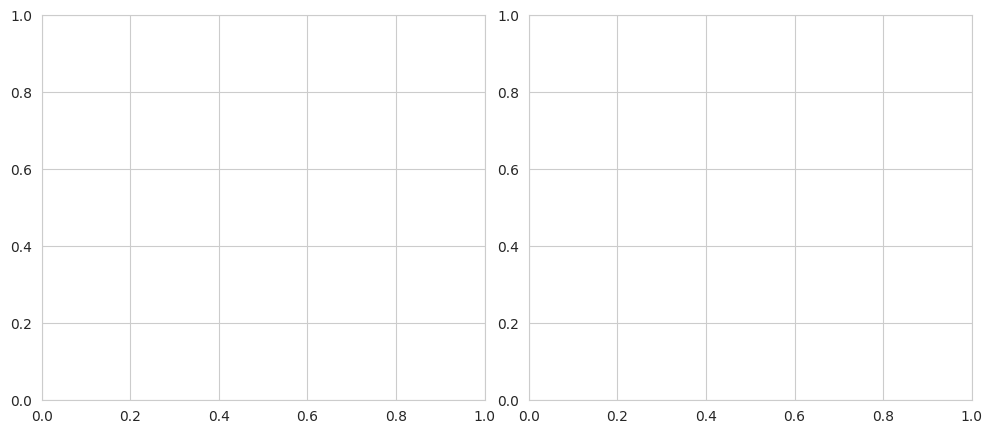

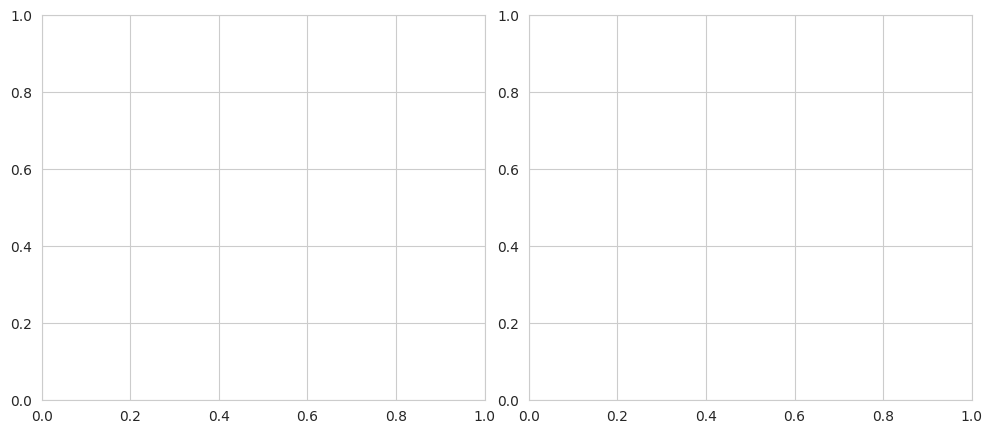

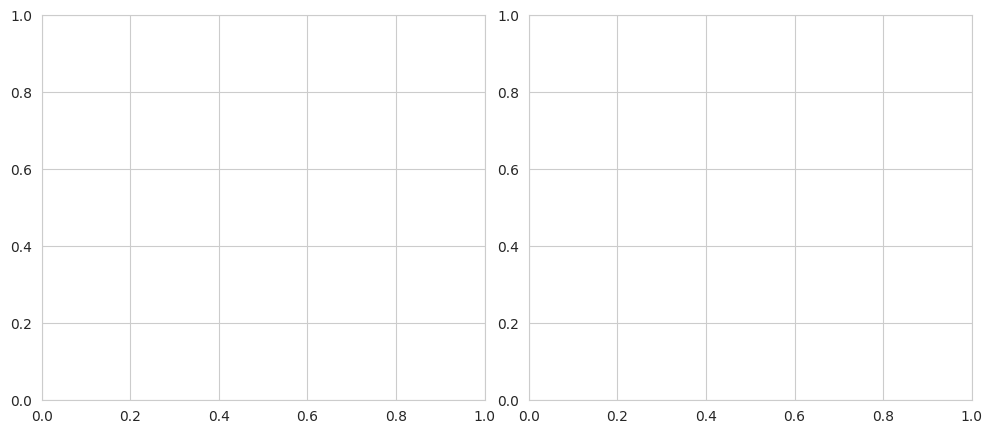

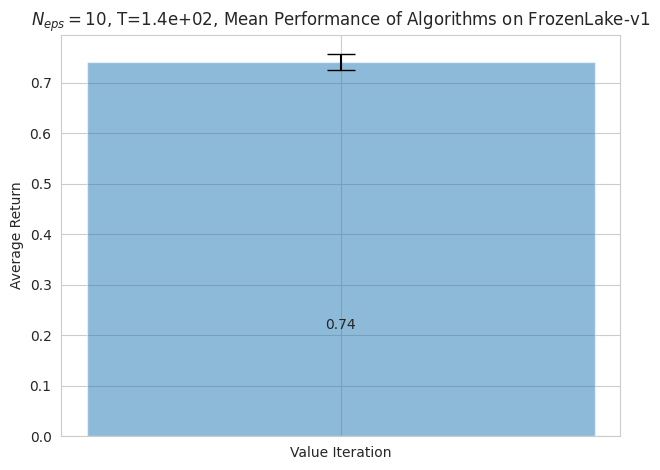

Using existing Axes for plot_vi_subset_fr_combine_10_FrozenLake-v1_N10_mean_seed_combine
Plotting for 31
keys: dict_keys(['0_valiter', '0_qling-dsd', '0_qling', '0_qling-lcb', '1_valiter', '1_qling-dsd', '1_qling', '1_qling-lcb', '2_valiter', '2_qling-dsd', '2_qling', '2_qling-lcb', '3_valiter', '3_qling-dsd', '3_qling', '3_qling-lcb', '4_valiter', '4_qling-dsd', '4_qling', '4_qling-lcb', 'extra_info'])


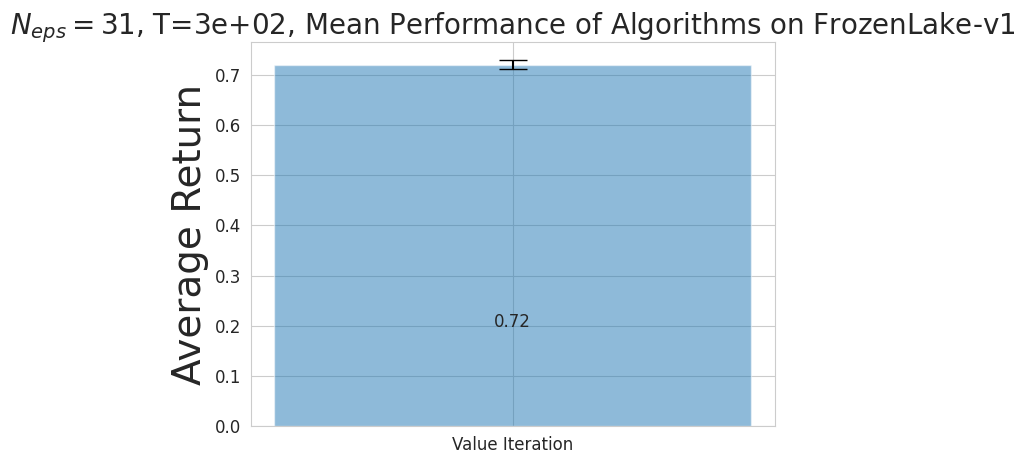

Using existing Axes for plot_vi_subset_fr_combine_31_FrozenLake-v1_N31_mean_seed_combine
Plotting for 100
keys: dict_keys(['0_valiter', '0_qling-dsd', '0_qling', '0_qling-lcb', '1_valiter', '1_qling-dsd', '1_qling', '1_qling-lcb', '2_valiter', '2_qling-dsd', '2_qling', '2_qling-lcb', '3_valiter', '3_qling-dsd', '3_qling', '3_qling-lcb', '4_valiter', '4_qling-dsd', '4_qling', '4_qling-lcb', 'extra_info'])


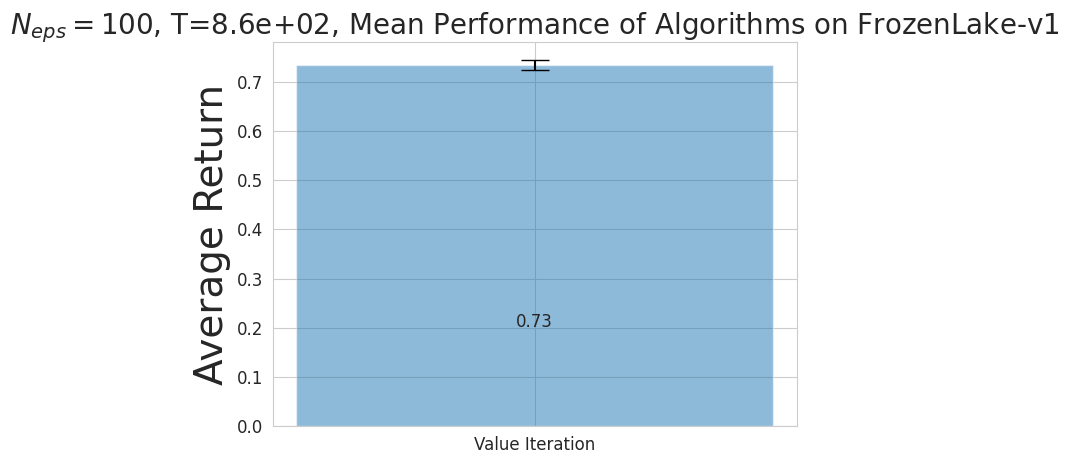

Using existing Axes for plot_vi_subset_fr_combine_100_FrozenLake-v1_N100_mean_seed_combine
Plotting for 316
keys: dict_keys(['0_valiter', '0_qling-dsd', '0_qling', '0_qling-lcb', '1_valiter', '1_qling-dsd', '1_qling', '1_qling-lcb', '2_valiter', '2_qling-dsd', '2_qling', '2_qling-lcb', '3_valiter', '3_qling-dsd', '3_qling', '3_qling-lcb', '4_valiter', '4_qling-dsd', '4_qling', '4_qling-lcb', 'extra_info'])


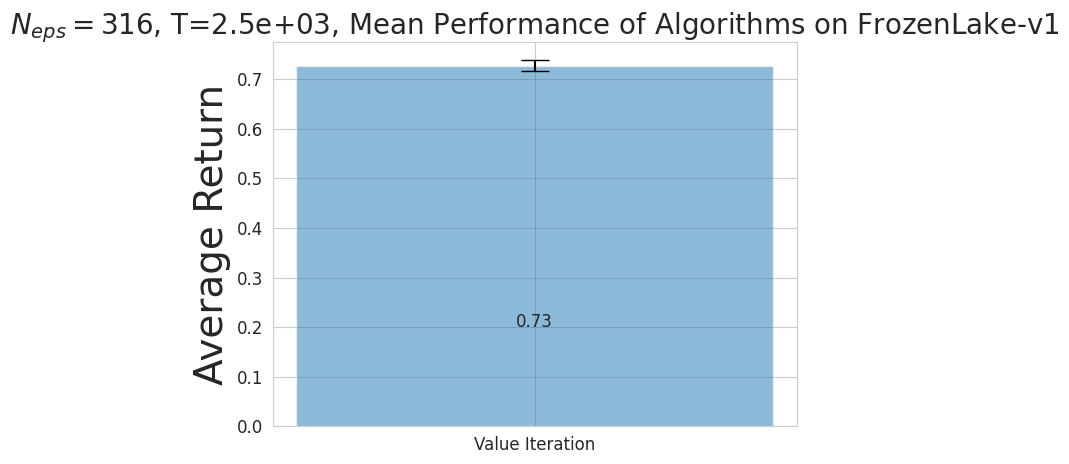

Using existing Axes for plot_vi_subset_fr_combine_316_FrozenLake-v1_N316_mean_seed_combine
Plotting for 1000
keys: dict_keys(['0_valiter', '0_qling-dsd', '0_qling', '0_qling-lcb', '1_valiter', '1_qling-dsd', '1_qling', '1_qling-lcb', '2_valiter', '2_qling-dsd', '2_qling', '2_qling-lcb', '3_valiter', '3_qling-dsd', '3_qling', '3_qling-lcb', '4_valiter', '4_qling-dsd', '4_qling', '4_qling-lcb', 'extra_info'])


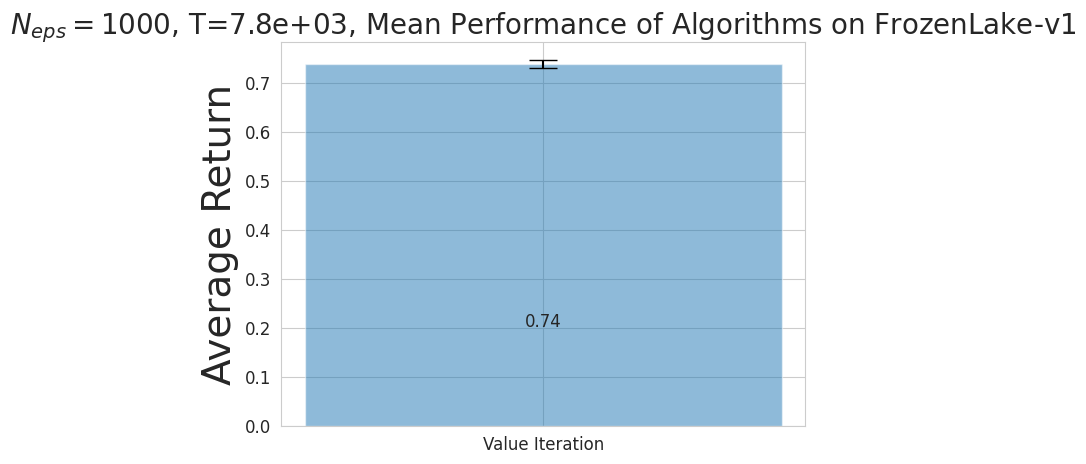

Using existing Axes for plot_vi_subset_fr_combine_1000_FrozenLake-v1_N1000_mean_seed_combine
Plotting for 3162
keys: dict_keys(['0_valiter', '0_qling-dsd', '0_qling', '0_qling-lcb', '1_valiter', '1_qling-dsd', '1_qling', '1_qling-lcb', '2_valiter', '2_qling-dsd', '2_qling', '2_qling-lcb', '3_valiter', '3_qling-dsd', '3_qling', '3_qling-lcb', '4_valiter', '4_qling-dsd', '4_qling', '4_qling-lcb', 'extra_info'])


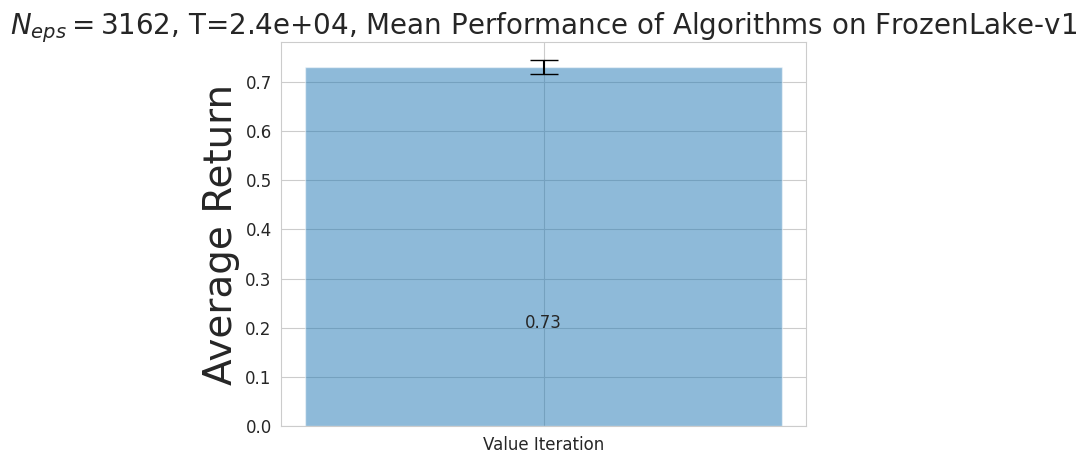

Using existing Axes for plot_vi_subset_fr_combine_3162_FrozenLake-v1_N3162_mean_seed_combine
Plotting for 10
keys: dict_keys(['0_valiter', '0_qling-dsd', '0_qling', '0_qling-lcb', '1_valiter', '1_qling-dsd', '1_qling', '1_qling-lcb', '2_valiter', '2_qling-dsd', '2_qling', '2_qling-lcb', '3_valiter', '3_qling-dsd', '3_qling', '3_qling-lcb', '4_valiter', '4_qling-dsd', '4_qling', '4_qling-lcb', 'extra_info', '0_qling-dsd-knownp', '1_qling-dsd-knownp', '2_qling-dsd-knownp', '3_qling-dsd-knownp', '4_qling-dsd-knownp'])
 Scaling x by 2 since plotting qling


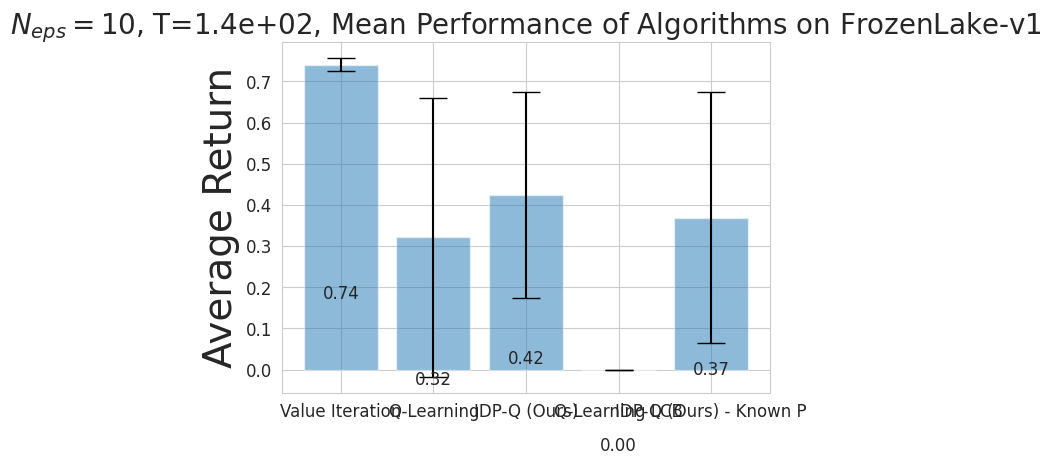

Using existing Axes for plot_qling_subset_fr_postfix_combine_10_FrozenLake-v1_N10_mean_seed_combine
Plotting for 31
keys: dict_keys(['0_valiter', '0_qling-dsd', '0_qling', '0_qling-lcb', '1_valiter', '1_qling-dsd', '1_qling', '1_qling-lcb', '2_valiter', '2_qling-dsd', '2_qling', '2_qling-lcb', '3_valiter', '3_qling-dsd', '3_qling', '3_qling-lcb', '4_valiter', '4_qling-dsd', '4_qling', '4_qling-lcb', 'extra_info', '0_qling-dsd-knownp', '1_qling-dsd-knownp', '2_qling-dsd-knownp', '3_qling-dsd-knownp', '4_qling-dsd-knownp'])
 Scaling x by 2 since plotting qling


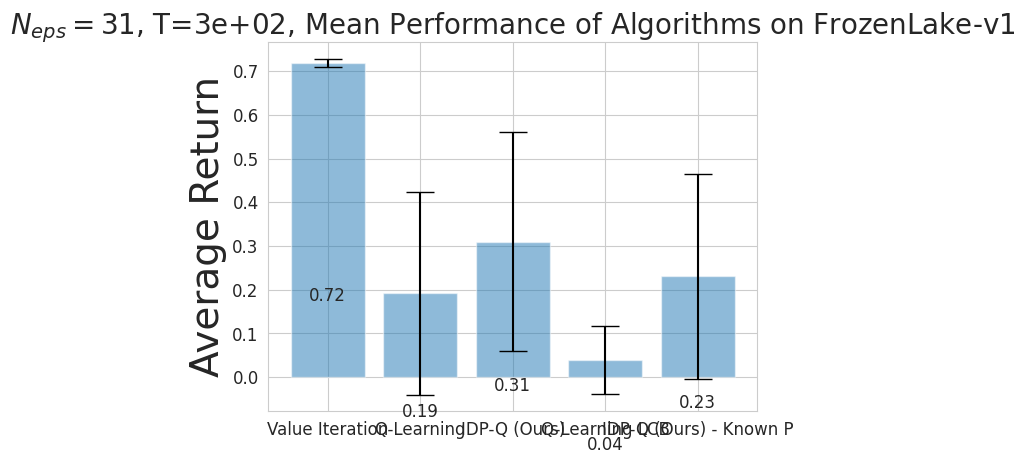

Using existing Axes for plot_qling_subset_fr_postfix_combine_31_FrozenLake-v1_N31_mean_seed_combine
Plotting for 100
keys: dict_keys(['0_valiter', '0_qling-dsd', '0_qling', '0_qling-lcb', '1_valiter', '1_qling-dsd', '1_qling', '1_qling-lcb', '2_valiter', '2_qling-dsd', '2_qling', '2_qling-lcb', '3_valiter', '3_qling-dsd', '3_qling', '3_qling-lcb', '4_valiter', '4_qling-dsd', '4_qling', '4_qling-lcb', 'extra_info', '0_qling-dsd-knownp', '1_qling-dsd-knownp', '2_qling-dsd-knownp', '3_qling-dsd-knownp', '4_qling-dsd-knownp'])
 Scaling x by 2 since plotting qling


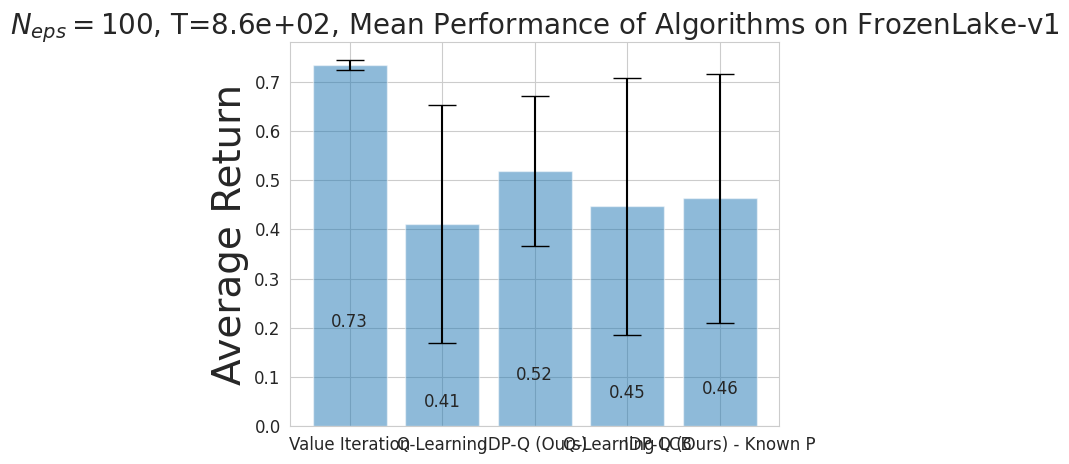

Using existing Axes for plot_qling_subset_fr_postfix_combine_100_FrozenLake-v1_N100_mean_seed_combine
Plotting for 316
keys: dict_keys(['0_valiter', '0_qling-dsd', '0_qling', '0_qling-lcb', '1_valiter', '1_qling-dsd', '1_qling', '1_qling-lcb', '2_valiter', '2_qling-dsd', '2_qling', '2_qling-lcb', '3_valiter', '3_qling-dsd', '3_qling', '3_qling-lcb', '4_valiter', '4_qling-dsd', '4_qling', '4_qling-lcb', 'extra_info', '0_qling-dsd-knownp', '1_qling-dsd-knownp', '2_qling-dsd-knownp', '3_qling-dsd-knownp', '4_qling-dsd-knownp'])
 Scaling x by 2 since plotting qling


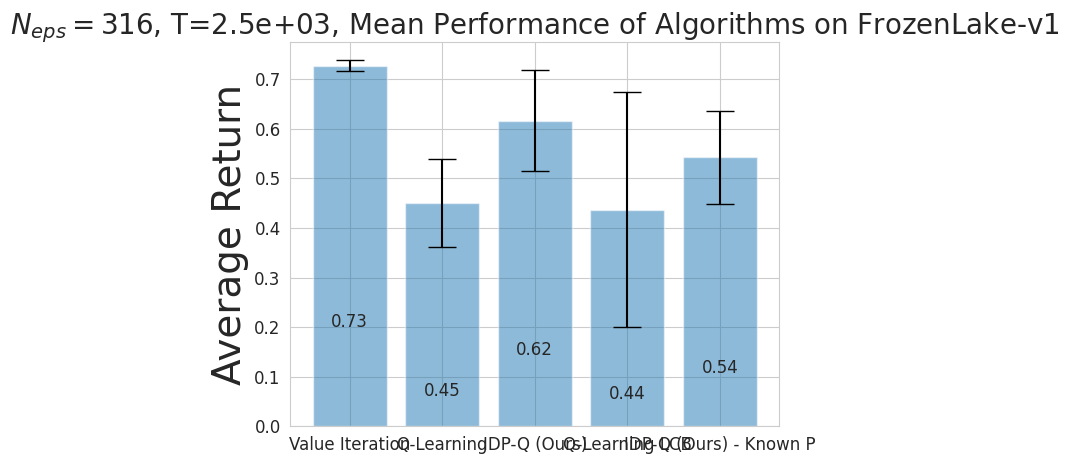

Using existing Axes for plot_qling_subset_fr_postfix_combine_316_FrozenLake-v1_N316_mean_seed_combine
Plotting for 1000
keys: dict_keys(['0_valiter', '0_qling-dsd', '0_qling', '0_qling-lcb', '1_valiter', '1_qling-dsd', '1_qling', '1_qling-lcb', '2_valiter', '2_qling-dsd', '2_qling', '2_qling-lcb', '3_valiter', '3_qling-dsd', '3_qling', '3_qling-lcb', '4_valiter', '4_qling-dsd', '4_qling', '4_qling-lcb', 'extra_info', '0_qling-dsd-knownp', '1_qling-dsd-knownp', '2_qling-dsd-knownp', '3_qling-dsd-knownp', '4_qling-dsd-knownp'])
 Scaling x by 2 since plotting qling


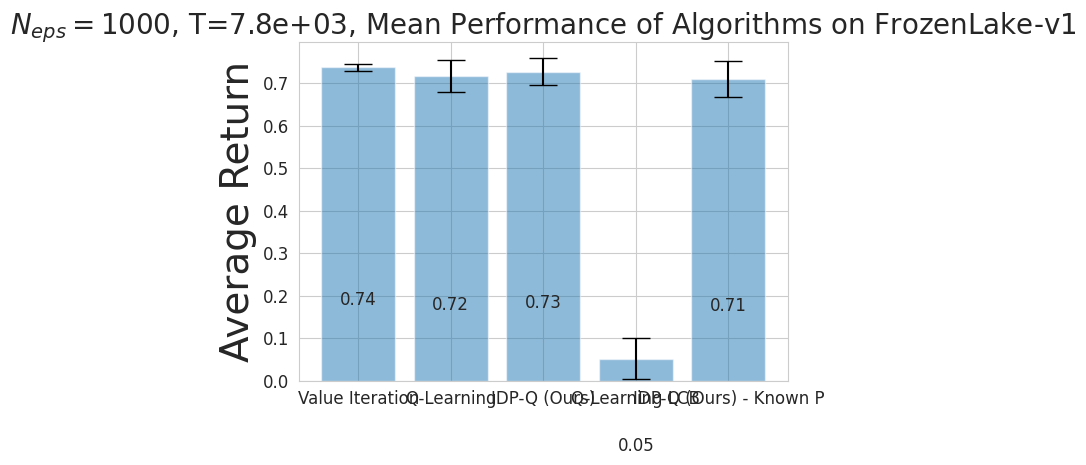

Using existing Axes for plot_qling_subset_fr_postfix_combine_1000_FrozenLake-v1_N1000_mean_seed_combine
Plotting for 3162
keys: dict_keys(['0_valiter', '0_qling-dsd', '0_qling', '0_qling-lcb', '1_valiter', '1_qling-dsd', '1_qling', '1_qling-lcb', '2_valiter', '2_qling-dsd', '2_qling', '2_qling-lcb', '3_valiter', '3_qling-dsd', '3_qling', '3_qling-lcb', '4_valiter', '4_qling-dsd', '4_qling', '4_qling-lcb', 'extra_info', '0_qling-dsd-knownp', '1_qling-dsd-knownp', '2_qling-dsd-knownp', '3_qling-dsd-knownp', '4_qling-dsd-knownp'])
 Scaling x by 2 since plotting qling


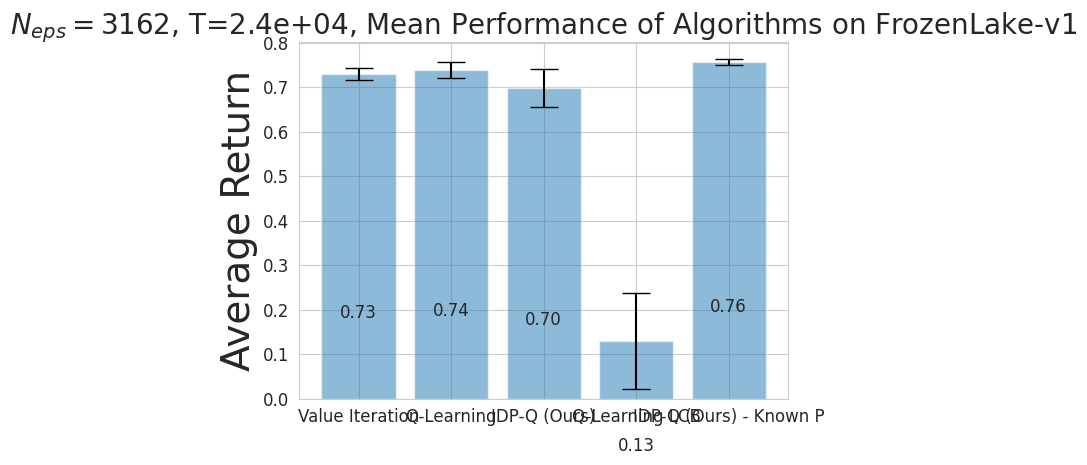

Using existing Axes for plot_qling_subset_fr_postfix_combine_3162_FrozenLake-v1_N3162_mean_seed_combine
mkdir: cannot create directory ‘img/vi_frozen_rand’: File exists
mkdir: cannot create directory ‘log/vi_frozen_rand’: File exists
trainperf_plot_vi_subset_fr_combine_1000_FrozenLake-v1_N1000_mean_seed_combine.png
renaming trainperf_plot_vi_subset_fr_combine_1000_FrozenLake-v1_N1000_mean_seed_combine.png to img/vi_frozen_rand/FrozenLake-v1_N1000
FrozenLake-v1_N31.png
plot_vi_subset_fr_combine_3162_FrozenLake-v1_N3162_mean_seed_combine_FrozenLake-v1_HPARAM_bar.png
FrozenLake-v1_N316.png
trainperf_plot_vi_subset_fr_combine_316_FrozenLake-v1_N316_mean_seed_combine.png
renaming trainperf_plot_vi_subset_fr_combine_316_FrozenLake-v1_N316_mean_seed_combine.png to img/vi_frozen_rand/FrozenLake-v1_N316
FrozenLake-v1_N1000.png
plot_vi_subset_fr_combine_31_FrozenLake-v1_N31_mean_seed_combine_FrozenLake-v1_HPARAM_bar.png
plot_vi_subset_fr_combine_316_FrozenLake-v1_N316_mean_seed_combine_FrozenLak

name,mean,std
Dataset Size (N),7817.2000,0.000000
Value Iteration,0.7376,0.007965


searching log/vi_frozen_rand/
plot_vi_subset_fr_combine_10_FrozenLake-v1_N10_mean_seed_combine.csv
plot_vi_subset_fr_combine_1000_FrozenLake-v1_N1000_mean_seed_combine.csv
plot_vi_subset_fr_combine_100_FrozenLake-v1_N100_mean_seed_combine.csv
plot_vi_subset_fr_combine_3162_FrozenLake-v1_N3162_mean_seed_combine.csv
plot_vi_subset_fr_combine_316_FrozenLake-v1_N316_mean_seed_combine.csv
plot_vi_subset_fr_combine_31_FrozenLake-v1_N31_mean_seed_combine.csv


Dataset Size (N),Value Iteration,Num. Episodes
1.4e+02,0.74,10
2.4e+04,0.73,3162
2.5e+03,0.73,316
3e+02,0.72,31
7.8e+03,0.74,1000
8.6e+02,0.73,100


mkdir: cannot create directory ‘img/qling_frozen_rand’: File exists
mkdir: cannot create directory ‘log/qling_frozen_rand’: File exists
plot_qling_subset_fr_postfix_combine_10_FrozenLake-v1_N10_mean_seed_combine_FrozenLake-v1_HPARAM_bar.png
FrozenLake-v1_N31.png
trainperf_plot_qling_subset_fr_postfix_combine_1000_FrozenLake-v1_N1000_mean_seed_combine.png
renaming trainperf_plot_qling_subset_fr_postfix_combine_1000_FrozenLake-v1_N1000_mean_seed_combine.png to img/qling_frozen_rand/FrozenLake-v1_N1000
plot_qling_subset_fr_postfix_combine_3162_FrozenLake-v1_N3162_mean_seed_combine_FrozenLake-v1_HPARAM_bar.png
plot_qling_subset_fr_postfix_combine_316_FrozenLake-v1_N316_mean_seed_combine_FrozenLake-v1_HPARAM_bar.png
trainperf_plot_qling_subset_fr_postfix_combine_3162_FrozenLake-v1_N3162_mean_seed_combine.png
renaming trainperf_plot_qling_subset_fr_postfix_combine_3162_FrozenLake-v1_N3162_mean_seed_combine.png to img/qling_frozen_rand/FrozenLake-v1_N3162
FrozenLake-v1_N316.png
trainperf_plot

name,mean,std
Dataset Size (N),7817.2000,0.000000
Value Iteration,0.7376,0.007965
Q-Learning,0.7168,0.037955
IDP-Q (Ours),0.7272,0.032065
Q-Learning LCB,0.0522,0.049036
IDP-Q (Ours) - Known P,0.7108,0.041887


searching log/qling_frozen_rand/
plot_qling_subset_fr_postfix_combine_3162_FrozenLake-v1_N3162_mean_seed_combine.csv
plot_qling_subset_fr_postfix_combine_1000_FrozenLake-v1_N1000_mean_seed_combine.csv
plot_qling_subset_fr_postfix_combine_316_FrozenLake-v1_N316_mean_seed_combine.csv
plot_qling_subset_fr_postfix_combine_100_FrozenLake-v1_N100_mean_seed_combine.csv
plot_qling_subset_fr_postfix_combine_31_FrozenLake-v1_N31_mean_seed_combine.csv
plot_qling_subset_fr_postfix_combine_10_FrozenLake-v1_N10_mean_seed_combine.csv


Dataset Size (N),Value Iteration,Q-Learning,IDP-Q (Ours),Q-Learning LCB,IDP-Q (Ours) - Known P,Num. Episodes
1.4e+02,0.74,0.32,0.42,0.00,0.37,10
2.4e+04,0.73,0.74,0.70,0.13,0.76,3162
2.5e+03,0.73,0.45,0.62,0.44,0.54,316
3e+02,0.72,0.19,0.31,0.04,0.23,31
7.8e+03,0.74,0.72,0.73,0.05,0.71,1000
8.6e+02,0.73,0.41,0.52,0.45,0.46,100


name,mean,std
Dataset Size (N),7817.2000,0.000000
Value Iteration,0.7376,0.007965


searching log/vi_frozen_rand/
plot_vi_subset_fr_combine_10_FrozenLake-v1_N10_mean_seed_combine.csv
plot_vi_subset_fr_combine_1000_FrozenLake-v1_N1000_mean_seed_combine.csv
plot_vi_subset_fr_combine_100_FrozenLake-v1_N100_mean_seed_combine.csv
plot_vi_subset_fr_combine_3162_FrozenLake-v1_N3162_mean_seed_combine.csv
plot_vi_subset_fr_combine_316_FrozenLake-v1_N316_mean_seed_combine.csv
plot_vi_subset_fr_combine_31_FrozenLake-v1_N31_mean_seed_combine.csv


Dataset Size (N),Value Iteration,Num. Episodes
1.4e+02,0.74,10
2.4e+04,0.73,3162
2.5e+03,0.73,316
3e+02,0.72,31
7.8e+03,0.74,1000
8.6e+02,0.73,100


name,mean,std
Dataset Size (N),7817.2000,0.000000
Value Iteration,0.7376,0.007965
Q-Learning,0.7168,0.037955
IDP-Q (Ours),0.7272,0.032065
Q-Learning LCB,0.0522,0.049036
IDP-Q (Ours) - Known P,0.7108,0.041887


searching log/qling_frozen_rand/
plot_qling_subset_fr_postfix_combine_3162_FrozenLake-v1_N3162_mean_seed_combine.csv
plot_qling_subset_fr_postfix_combine_1000_FrozenLake-v1_N1000_mean_seed_combine.csv
plot_qling_subset_fr_postfix_combine_316_FrozenLake-v1_N316_mean_seed_combine.csv
plot_qling_subset_fr_postfix_combine_100_FrozenLake-v1_N100_mean_seed_combine.csv
plot_qling_subset_fr_postfix_combine_31_FrozenLake-v1_N31_mean_seed_combine.csv
plot_qling_subset_fr_postfix_combine_10_FrozenLake-v1_N10_mean_seed_combine.csv


Dataset Size (N),Value Iteration,Q-Learning,IDP-Q (Ours),Q-Learning LCB,IDP-Q (Ours) - Known P,Num. Episodes
1.4e+02,0.74,0.32,0.42,0.00,0.37,10
2.4e+04,0.73,0.74,0.70,0.13,0.76,3162
2.5e+03,0.73,0.45,0.62,0.44,0.54,316
3e+02,0.72,0.19,0.31,0.04,0.23,31
7.8e+03,0.74,0.72,0.73,0.05,0.71,1000
8.6e+02,0.73,0.41,0.52,0.45,0.46,100


Merging
Missing some columns! log/qling_frozen_rand/ filterFroz
files are ['plot_qling_subset_fr_postfix_combine_3162_FrozenLake-v1_N3162_mean_seed_combine.csv', 'plot_qling_subset_fr_postfix_combine_1000_FrozenLake-v1_N1000_mean_seed_combine.csv', 'plot_qling_subset_fr_postfix_combine_316_FrozenLake-v1_N316_mean_seed_combine.csv', 'plot_qling_subset_fr_postfix_combine_100_FrozenLake-v1_N100_mean_seed_combine.csv', 'plot_qling_subset_fr_postfix_combine_31_FrozenLake-v1_N31_mean_seed_combine.csv', 'plot_qling_subset_fr_postfix_combine_10_FrozenLake-v1_N10_mean_seed_combine.csv']


Dataset Size (N),Value Iteration,Num. Episodes,Q-Learning,IDP-Q (Ours),Q-Learning LCB,IDP-Q (Ours) - Known P
1.4e+02,0.74,10,0.32,0.42,0.00,0.37
2.4e+04,0.73,3162,0.74,0.70,0.13,0.76
2.5e+03,0.73,316,0.45,0.62,0.44,0.54
3e+02,0.72,31,0.19,0.31,0.04,0.23
7.8e+03,0.74,1000,0.72,0.73,0.05,0.71
8.6e+02,0.73,100,0.41,0.52,0.45,0.46


fr


Dataset Size (N),Value Iteration,Num. Episodes,Q-Learning,IDP-Q (Ours),Q-Learning LCB,IDP-Q (Ours) - Known P
1.4e+02,0.74,10,0.32,0.42,0.00,0.37
2.4e+04,0.73,3162,0.74,0.70,0.13,0.76
2.5e+03,0.73,316,0.45,0.62,0.44,0.54
3e+02,0.72,31,0.19,0.31,0.04,0.23
7.8e+03,0.74,1000,0.72,0.73,0.05,0.71
8.6e+02,0.73,100,0.41,0.52,0.45,0.46


In [4]:
# Create all plots
vi_subset = [value_iter_extension, cql_extension, lcb_paper_extension, lcb_extension, dsd_extension, vanilla_extension]
ql_subset = [value_iter_extension, cql_extension, qling_extension, qling_dsd_extension, qling_lcb_extension]
ql_subset_estp = ql_subset.copy()
ql_subset_estp.append(qling_dsd_extension+"-knownp")

# run_options = ('rPpf','her') # Use to plot all
run_options = ('f','r')
vline = (0.1,0.2, 0.5, 1,2, 3)  # Markers to draw vertical lines (factor of T)

output_df_dict = {}
best_hparams_dict = {}
plot_graphs = True
for env_l, diff_l in itertools.product(*run_options):
    expt = f"{env_l}{diff_l}"
    result_files = get_pkl(expt)
    if result_files is None:
        print(f"skipping {expt}")
        continue
    pickle_output_filenames, env_name, postfix_groups, qxlim = result_files
    vi_subset_filter = filter_subset_expt(expt, vi_subset)
    
    # Make common plots
    if plot_graphs:
        axes_list = []
        for _ in range(7):
            fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=False, sharey=False)
            axes_list.append((fig, axes))
            fig.subplots_adjust(wspace=.1, hspace=0)
    
        # Plot things
        plot_all_pickled_outputs(pickle_output_filenames,#, postfix_groups=postfix_groups,
                                             extra_exp_prefix=f"plot_vi_subset_{expt}", env_name=env_name,
                                 axes=axes_list, qling_mode=False,
                                     run_subset=vi_subset_filter, xlim=None, vline=vline)  # VI
        plot_all_pickled_outputs_postfix(pickle_output_filenames, postfix_groups=postfix_groups,
                                         axes=axes_list, qling_mode=True,
                                                 extra_exp_prefix=f"plot_qling_subset_{expt}", env_name=env_name,
                                         run_subset=ql_subset_estp, xlim=qxlim, vline=vline)  # QL
    output_df = make_folders_and_move_then_rename(expt, plots_made=plot_graphs)
    output_df_dict[expt]= output_df
    
    # Get selected hparams
    hplog = HParamLogger()
    aggregated_counters = hplog.load_pickle_files_get_params(pickle_output_filenames, env_name=env_name, extra_exp_prefix="counters", postfix_groups=postfix_groups)
    best_hparams_dict[expt] = hplog.get_topk_agg(aggregated_counters,3)

for expt in output_df_dict:
    print(expt)
    display(HTML(output_df_dict[expt].to_html(index=False)))
    
    

## Format and display final table

In [5]:
def format_output_df_dict(output_df_dict):
    formatted_output_df = {}

    for expt in output_df_dict:
        scaling_exp = int(np.floor(np.log10(output_df_dict[expt].dropna()[dataset_col_name].apply(lambda x: float(x)).mean())))
        scaling_factor = 10**scaling_exp
        output_df = output_df_dict[expt].copy()
        output_df[dataset_col_name] = output_df[dataset_col_name].apply(lambda x: f"{float(x)/scaling_factor:.2f}")
        formatted_output_df[expt] = output_df.rename(columns={dataset_col_name: f"{dataset_col_name} $( \\times 10^{scaling_exp})$ "})
    return formatted_output_df

In [6]:
formatted_output_df = format_output_df_dict(output_df_dict)
for expt in formatted_output_df:
    print(expt)
    display(HTML(formatted_output_df[expt].dropna().to_html(index=False)))
    
# output_df_dict['fe']['Dataset Size (N)'].apply(lambda x: float(x)/1e3)

fr


Dataset Size (N) $( \times 10^3)$,Value Iteration,Num. Episodes,Q-Learning,IDP-Q (Ours),Q-Learning LCB,IDP-Q (Ours) - Known P
0.14,0.74,10,0.32,0.42,0.00,0.37
24.00,0.73,3162,0.74,0.70,0.13,0.76
2.50,0.73,316,0.45,0.62,0.44,0.54
0.30,0.72,31,0.19,0.31,0.04,0.23
7.80,0.74,1000,0.72,0.73,0.05,0.71
0.86,0.73,100,0.41,0.52,0.45,0.46


In [7]:
best_hparams_dict

{'fr': {'valiter': {},
  'qling-dsd': {'eta': (0.1, 8),
   'gamma_b': (1.0, 30),
   'alpha_b': (0.01, 18),
   'beta_b': (0.0, 26)},
  'qling': {'eta': (0.1, 14)},
  'qling-lcb': {'eta': (0.1, 10), 'cb': (0.01, 15)},
  'qling-dsd-knownp': {'eta': (0.1, 8),
   'gamma_b': (1.0, 30),
   'alpha_b': (0.01, 11),
   'beta_b': (0.0, 26)}}}

In [8]:
# mv log/ql* log/vi_* predeadline_plots_logs/log/